In [1]:
import glob 
import os
import matplotlib.pyplot as plt
import pims as pm
from pims import pipeline # To analyze one frame at each time
import trackpy as tp # To do the tracking
import numpy as np
import pandas as pd

# To convert to gray scale one by one each image of the video
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

# Tracking

In  this script, I will develop an algorith to track the particles. 

In [2]:
directory = "/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/"

filenames = [file for file in glob.glob(
    os.path.join(directory,('EXP8_2023_03_23_16_25*.avi')))]
filenames

['/media/Carol/Magnetic/Experiments/Microfluidics_experiments/with-interaction/21_24-04-2023_Preliminar-experiments/EXP8_2023_03_23_16_25_36.avi']

# Functions and parameters used in the tracking loop

In [4]:
min_travelled_distance = -200
diameter = 11
radius = diameter/2

In [5]:
# Maybe I need to generate a file that introduce the values of the empty channel frame.  

In [6]:
def mean(video):

    frames = video[0]
    for i in range(1, len(video), 1):

        frames = frames + video[i]
        
    mean = frames/len(video)
    return mean

In [7]:
def substraction(frame, mean, video):
    """ This function substracts a frame where the channel is empty to all the particles.
        This procedure helps to enhance difference among frames and then contrast to perform the tracking."""
    
    frame_sub = (mean- video[frame].astype(np.int8))
    
    return frame_sub

In [8]:
def filtering_particles_passed_channel(df, min_travelled_distance):
    """ In this function I will filter only the particles that passed throught the channel. 
        This will be done by filtering the particles that has travelled a minimum distance."""
    
    df["l_travelled"] = df.groupby("particle")["x"].transform(lambda x: x - x.max())
    particles_in_channel = (df.groupby('particle')['l_travelled'].min() > min_travelled_distance).to_frame()
    particles_in_channel = particles_in_channel.loc[particles_in_channel.l_travelled, :]
    no_passed = particles_in_channel.index.unique()
    df = df.drop(index=no_passed, level = 1)

    return df

In [9]:
def analyze_whole_vid(video,filename):
        loc_df = []
        # The following loop perform the tracking
        mean_v = mean(video)
        for i in range(0,len(video), 1): # Analyze 1 frame each 5 frame
            #print(i)
            sub = substraction(i, mean_v, video) # change the frame where the channel is empty
            loc = tp.locate(sub,2*round(radius)+1,threshold = 0,separation = diameter/2,minmass = 170)
            loc['frame'] = i
            loc_df.append(loc.copy(deep = True))
            
        location = pd.concat(loc_df)
        location.to_csv(filename[:filename.find(".avi")]+"_location.dat", sep = "\t")

        return location

# Loop to analyze all the videos

In [10]:
@pipeline 
def locate_and_track(filename):
    
    print(filename)
    video = pm.open(filename)
    video = as_gray(video)
    print(len(video))

    location = analyze_whole_vid(video,filename)
    # Here we filter the particles that passed through the channel 

    tracking = tp.link(location,10, memory = 20, neighbor_strategy= 'KDTree') # Generate the trajectories
    tracking = tracking.set_index(["frame","particle"])
    track = filtering_particles_passed_channel(tracking, min_travelled_distance = -200)

    # Saving the data
    track.to_csv(filename[:filename.find(".avi")]+"_tracking.dat", sep="\t")
    
[locate_and_track(f) for f in filenames[:]]

Frame 6327: 113 trajectories present.


[None]

# Show trajectories of all the analyzed experiments 

In [11]:
n_rows = len(filenames)
n_rows

1

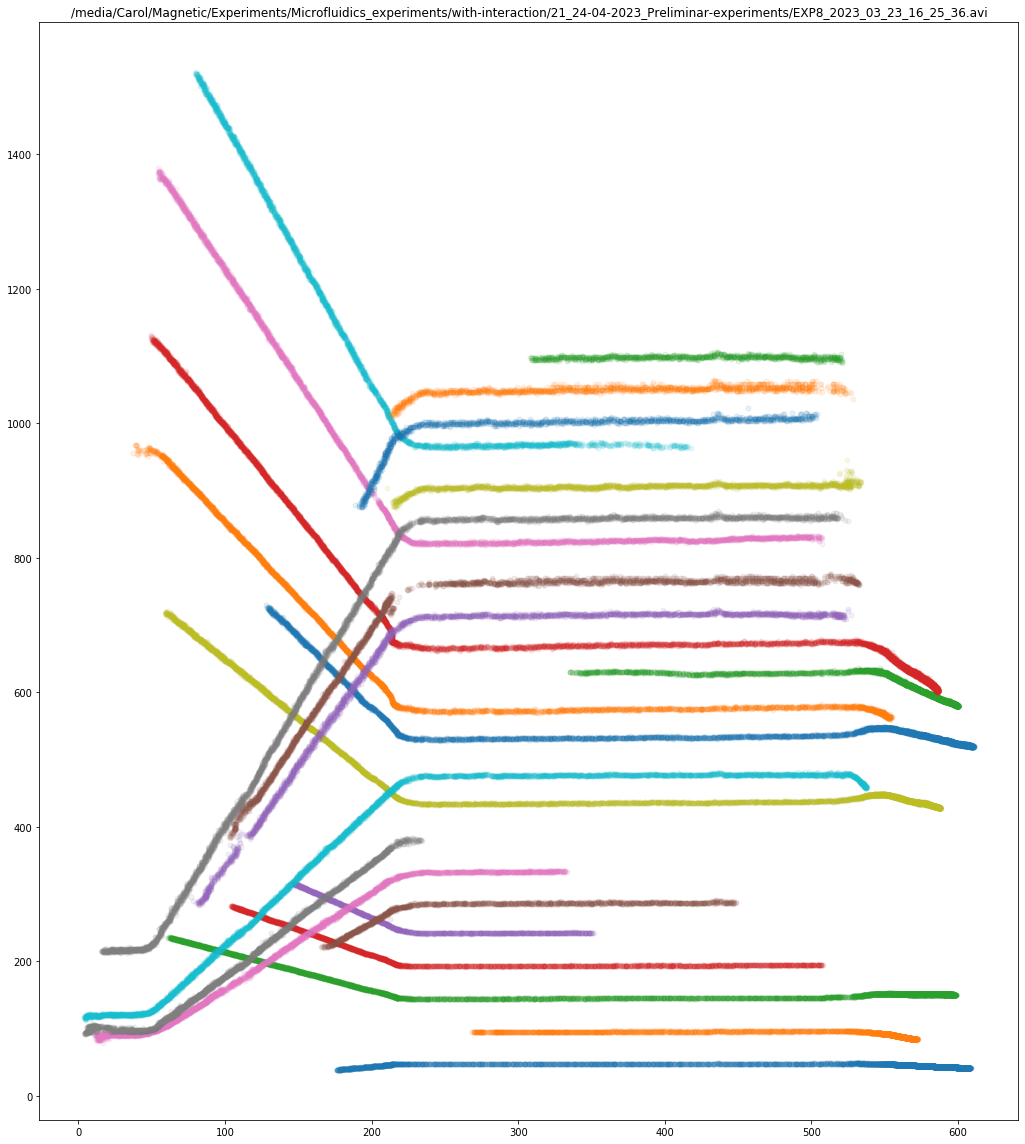

In [16]:
fig, ax = plt.subplots(int(n_rows),1,figsize=(15,16*n_rows))


for file_no, filename in enumerate(filenames[0:]):

    trj = pd.read_csv(filename[:filename.find(".avi")]+"_tracking.dat", index_col = [0,1], sep ="\t")
        
    #video = pm.open(filename)

    #ax.flatten()[file_no].imshow(video[file_no])
    #ax.flatten()[file_no].set_axis_off()
    i = 1
    for p,trj_p in trj.groupby("particle"):
#         ax.flatten()[file_no].plot(trj_p.x, trj_p.y*0.2*i, 'o', alpha = 0.1, markersize = 20)
#         ax.flatten()[file_no].set_title(str(filename))
      ax.plot(trj_p.x, trj_p.y*0.2*i, 'o', alpha = 0.1, markersize = 5)
      ax.set_title(str(filename))
      i =i + 1 
plt.tight_layout()